# Introduction to TSR distance estimation
## Reading the database


In [12]:
import pandas as pd
store = pd.HDFStore('store.h5')
df = store['df']
df.head()

Z                                  currImage              currRect  \
0  13.85  16-06-05_17-25-17_Single_0026_frame52.img  [117, 202, 650, 736]   
0   16.7  16-06-05_17-25-17_Single_0026_frame51.img  [200, 268, 625, 701]   
0   None  16-06-05_17-25-17_Single_0026_frame50.img  [257, 317, 615, 677]   

                                           egoMotion  focal  \
0  [[0.999999578399109, -0.000895476002401953, -0...   1612   
0  [[0.9999966311214874, -0.0025956984235227477, ...   1612   
0  [[0.9999998869381259, 0.00046968847719411973, ...   1612   

                                   prevImage              prevRect  
0  16-06-05_17-25-17_Single_0026_frame51.img  [200, 268, 625, 701]  
0  16-06-05_17-25-17_Single_0026_frame50.img  [257, 317, 615, 677]  
0  16-06-05_17-25-17_Single_0026_frame49.img  [299, 351, 605, 659]

### Image principal point 

In [13]:
from MEImage import *
image = MEImage()
image.from_file('./images/16-06-05_17-25-17_Single_0026_frame52.img')
print image._origin

[612 508]


### Focal length 

In [14]:
df['focal']

0    1612
0    1612
0    1612
Name: focal, dtype: int64

### Prev and current image rect

In [15]:
df['prevRect']
df['currRect']

0    [117, 202, 650, 736]
0    [200, 268, 625, 701]
0    [257, 317, 615, 677]
Name: currRect, dtype: object

### Ego motion matrix

In [16]:
# 1st part is rotation (3,3), translation vector
for index , row in df.iterrows():
    print row['egoMotion']
    print type(row['egoMotion']),row['egoMotion'].shape

[[ 9.99999578e-01 -8.95476002e-04 -2.03283874e-04  5.62752837e-02]
 [ 8.95523797e-04  9.99999571e-01  2.35143793e-04 -5.88343605e-02]
 [ 2.03073221e-04 -2.35325740e-04  9.99999952e-01 -2.89097313e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<type 'numpy.ndarray'> (4, 4)
[[ 9.99996631e-01 -2.59569842e-03 -9.76575490e-06  5.34051704e-02]
 [ 2.59569118e-03  9.99996400e-01 -6.80046032e-04 -5.12130713e-02]
 [ 1.15309142e-05  6.80018392e-04  9.99999769e-01 -2.88863401e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<type 'numpy.ndarray'> (4, 4)
[[ 9.99999887e-01  4.69688477e-04  7.42729400e-05  5.69971963e-02]
 [-4.69526179e-04  9.99997535e-01 -2.17027886e-03 -4.87108894e-02]
 [-7.52921118e-05  2.17024375e-03  9.99997642e-01 -2.88552559e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<type 'numpy.ndarray'> (4, 4)


### Display image

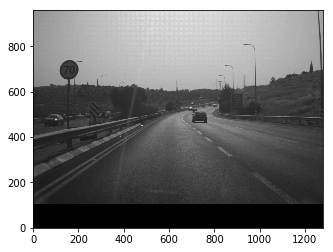

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
#flip up down image
plt.imshow(image.im,cmap='gray',origin='lower')


# Convolution using scipy

In [57]:
# create sobel arrays
sobel_x =np.array([[-1,0,1],[-2, 0, 2], [-1, 0, 1]])/8.
sobel_y = sobel_x.T

print "sobel_x:", sobel_x, "\n"
print "sobel_y:", sobel_y

sobel_x: [[-0.125  0.     0.125]
 [-0.25   0.     0.25 ]
 [-0.125  0.     0.125]] 

sobel_y: [[-0.125 -0.25  -0.125]
 [ 0.     0.     0.   ]
 [ 0.125  0.25   0.125]]


In [58]:
im_arr_obs = [image.from_file("./images/"+i) for i in df.currImage] 
im_arr = [ob.im for ob in im_arr_obs]
im_source = [ob._origin for ob in im_arr_obs]

In [59]:
from scipy import signal as sg

def sobel_filters(im, sobel_x, sobel_y):
    pdx = sg.convolve2d(im,sobel_x,"same")
    pdy = sg.convolve2d(im,sobel_y,"same")
    return pdx, pdy

pdx, pdy = sobel_filters(im_arr[0], sobel_x, sobel_y)

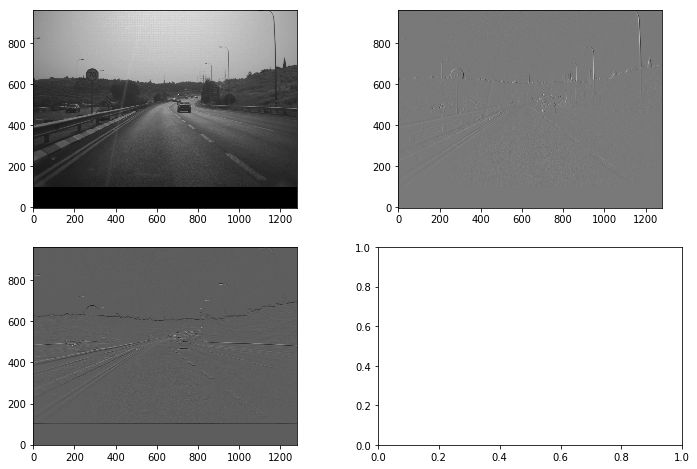

In [74]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
ax = axes.flatten()
ax[0].imshow(im_arr[0], cmap = "gray", origin='lower')
ax[1].imshow(pdx, cmap = "gray", origin='lower')
ax[2].imshow(pdy, cmap = "gray", origin='lower')

In [86]:
def harris(pdx,pdy, window_dim):
    window_arr = np.ones(window_dim)
    
    ix_iy = pdx*pdy

    summed_pix = sg.convolve2d(ix_iy,window_arr,"same")
    print sum(ix_iy)
    print sum(summed_pix)
    
harris(pdx, pdy, window_dim = (5,5))

[  -89.71875  -760.5     -1191.5625  ...   598.9375    817.3125
   264.21875]
[ -5368.703125 -10658.390625 -15317.671875 ...   7391.984375   5701.03125
   2397.484375]


In [78]:
window = np.ones((5,5))
window

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [ ]:
from MEImage import *
image = MEImage()
image.from_file('./images/16-06-05_17-25-17_Single_0026_frame52.img')
print image._origin

In [37]:
# calculate derivatives for x and y of image
from scipy import signal as sg

pdx = sg.convolve2d(myImage,sobel_x,"same") 
pdy = sg.convolve2d(image.im, sobel_y, "same")

In [18]:
from scipy import signal as sg

#create artifical image with constant positive slope 
myImage=np.zeros((5,5),dtype=float)
for y in range(5):
    for x in range(5):
        myImage[y,x]=y+x
myImage

array([[0., 1., 2., 3., 4.],
       [1., 2., 3., 4., 5.],
       [2., 3., 4., 5., 6.],
       [3., 4., 5., 6., 7.],
       [4., 5., 6., 7., 8.]])

In [19]:
sobelKernel=np.array([[-1,0,1],[-2, 0, 2], [-1, 0, 1]])/8.
sobelKernel

array([[-0.125,  0.   ,  0.125],
       [-0.25 ,  0.   ,  0.25 ],
       [-0.125,  0.   ,  0.125]])

In [24]:
sobelKernel

array([[-0.125,  0.   ,  0.125],
       [-0.25 ,  0.   ,  0.25 ],
       [-0.125,  0.   ,  0.125]])

In [20]:
pdx=sg.convolve2d(myImage,sobelKernel,"same") 
print "Input image:"
print myImage
print "Output Image:"
print pdx

Input image:
[[0. 1. 2. 3. 4.]
 [1. 2. 3. 4. 5.]
 [2. 3. 4. 5. 6.]
 [3. 4. 5. 6. 7.]
 [4. 5. 6. 7. 8.]]
Output Image:
[[-0.5  -0.75 -0.75 -0.75  1.25]
 [-1.   -1.   -1.   -1.    2.  ]
 [-1.5  -1.   -1.   -1.    2.5 ]
 [-2.   -1.   -1.   -1.    3.  ]
 [-1.75 -0.75 -0.75 -0.75  2.5 ]]


## Maximum filter  

In [21]:
from scipy.ndimage.filters import maximum_filter

print "Input image:"
print myImage
print "Output Image:"
print maximum_filter(myImage,5)

myImage == maxi

Input image:
[[0. 1. 2. 3. 4.]
 [1. 2. 3. 4. 5.]
 [2. 3. 4. 5. 6.]
 [3. 4. 5. 6. 7.]
 [4. 5. 6. 7. 8.]]
Output Image:
[[4. 5. 6. 6. 6.]
 [5. 6. 7. 7. 7.]
 [6. 7. 8. 8. 8.]
 [6. 7. 8. 8. 8.]
 [6. 7. 8. 8. 8.]]


## ndimage

In [22]:
from scipy import ndimage

## Final results

In [23]:
df['Z']

0    13.85
0     16.7
0     None
Name: Z, dtype: object